In [9]:
import os
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing import Optional, TypedDict, Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_tavily import TavilySearch
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

In [10]:

load_dotenv()


True

In [11]:
### --- LLm Configuration --- ###
llm = ChatOpenAI(
    model="openai/gpt-4o-mini",
    base_url="https://openrouter.ai/api/v1",
    temperature=0,
    api_key=os.getenv("OPENROUTER_API_KEY")
)

reasoner_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0
)

In [12]:
### defining tools ###
search_tools = TavilySearch(max_results=2)

In [13]:
### --- Models --- ###

class PlanStep(BaseModel):
    id: int = Field(..., description="The unique sequenital identifier for the step")
    description: str = Field(..., description="A description of the step to be taken")
    tool_required: bool = Field(..., description="Whether this step requires external search/tools?")
class PlanState(BaseModel):
    steps: list[PlanStep] = Field(description="List of the steps in the plan")
    rationale: str = Field(description="the reasoning behind the plan, why it is chosen.")

class ReflectorState(BaseModel):
    is_satisfactory: bool = Field(..., description="Whether the current plan and results answer the user's question?")
    feedback: str = Field(..., description="Critique of what is missing")
    next_step_adjustment: Optional[str] = Field(None, description="How to adjust the next steps if needed")

class AgentState(TypedDict):
    messages: Annotated[list[dict], add_messages]

    plan: Optional[PlanState]
    current_step: int
    step_results: dict[int, str]
    final_output: Optional[str]
    reflection: Optional[str]

    retry_cnt: int


In [14]:

### --- Node Definitions --- ###
def node_planner(state: AgentState):
    question = state['messages'][-1].content

    structured_llm = llm.with_structured_output(PlanState)

    is_retry = state["retry_cnt"] > 0

    if is_retry:
        feedback = state['reflection'].feedback
        
        prompt = f"""
            You are fixing a failed plan.
            The previous execution failed.
            Fedback from execution: {feedback}
        """
    else:
        prompt = f"""
            You are a Solution Architect. Break down the user's query into
            logical, sequantial steps. Be Precise. If it's a greeting, make a 1-step plan.
        """

    # pass the full message history for context
    res = structured_llm.invoke(
        SystemMessage(content=prompt) + state['messages']
    )

    return {
        'plan': res,
        'current_step': 0,
        'step_results': {}, # reset step results on new plan
        'retry_cnt': state.get('retry_cnt', -1) + 1,
    }

def node_executor(state: AgentState):
    plan = state['plan']
    idx: int = state['current_step']

    if idx >= len(plan.steps):
        return state
    
    curr_step = plan.steps[idx]

    if curr_step.tool_required:
        tool_chain = llm.bind_tools([search_tools])
        res = tool_chain.invoke(f"Perform this task: {curr_step.description}")

        if res.tool_calls:
            tool_call = res.tool_calls[0]
            output = search_tools.invoke(tool_call['args'])
            res = str(output)
        else:
            res = res.content
    
    else:
        res = llm.invoke(f"Reason through this: {curr_step.description}").content

    return {
        'step_results': {idx: res},
        'current_step':  idx + 1
    }

def node_reflector(state: AgentState):
    user_query = state['messages'][0].content
    plan = state['plan']
    step_results = state['step_results']

    structured_reasoner_llm = reasoner_llm.with_structured_output(ReflectorState)

    context = "\n".join([f"step {i} : {v}" for i,v in step_results.items()])

    prompt = f"""
        You are an expert reviewer. Given the user's query, the plan made, and the results so far, Stricly evaludate: Did we answer the request. If yes, mark is_satisfactory=True. If no, provide strict feedback on what is missing.

        user Query: {user_query}
        Plan: {plan}
        Executed Steps: {context}
    """

    res = structured_reasoner_llm.invoke(prompt)

    # we append the critique as a message for context in next planning
    return {
        'reflection': res,
        "messages": [AIMessage(content=f"Self-Reflection: {res}")]
    }

def node_synthesizer(state: AgentState):
    """Combines all the gathered infomation into a final human-readable answer."""

    step_results = state['step_results']
    user_query = state['messages'][0].content

    context = "\n".join([f"info found: {v}" for v in step_results.values()])

    prompt = f"""
        You are a helpful assistant. Using the information gathered from various steps, provide a concise and accurate answer to user query: '{user_query} using this data: \n{context}'
    """

    res = llm.invoke(prompt)

    return {
        'final_output': res.content
    }


In [15]:

def execution_router(state: AgentState):
    idx: int = state['current_step']
    plan = state['plan']

    if idx < len(plan.steps):
        return "executor"
    else:
        return "reflector"
    
def reflection_router(state: AgentState):
    reflection: ReflectorState = state['reflection']
    retries = state.get('retry_cnt', 0)
    MAX_RETRIES = 3 


    if reflection.is_satisfactory:
        return "synthesizer"
    elif retries < MAX_RETRIES:
        return "planner"
    else:
        print("Max retries reached. Proceeding to synthesizer.")
        return "synthesizer"

In [16]:


### --- Graph Definition --- ###
graph = StateGraph(AgentState)

# nodes
graph.add_node("planner", node_planner)
graph.add_node("executor", node_executor)
graph.add_node("reflector", node_reflector)
graph.add_node("synthesizer", node_synthesizer)

# edges
graph.add_edge(START, "planner")
graph.add_edge("planner", "executor")
graph.add_conditional_edges("executor", execution_router, {"executor": "executor", "reflector": "reflector"})
graph.add_conditional_edges("reflector", reflection_router, {"planner": "planner", "synthesizer": "synthesizer"})

graph.add_edge("synthesizer", END)

# compile
app = graph.compile()

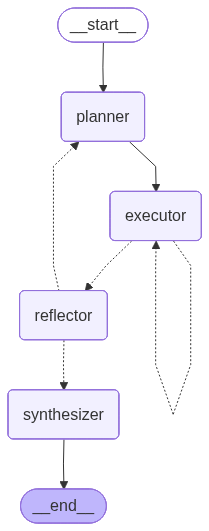

In [17]:
app